# Classical Bayesian optimisation

In [1]:
import jax
import numpy as np
import pandas as pd
import seaborn as sns
import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from functools import partial

In [2]:
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter

In [3]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [4]:
sns.set_palette("colorblind")
plt.rcParams["figure.figsize"] = (7.2, 4.2)

In [5]:
jnp.set_printoptions(suppress=False, precision=8, linewidth=200)

In [6]:
%config InlineBackend.figure_format = "retina"

In [7]:
def plot_hist(ax, runs, **kwargs):
    steps = np.arange(len(runs[0]))
    med_run = np.quantile(runs, 0.5, axis=0)
    # med_run = np.mean(runs, axis=0)
    lbound = np.quantile(runs, 0.25, axis=0)
    ubound = np.quantile(runs, 0.75, axis=0)

    
    ax.plot(med_run, **kwargs)
    ax.fill_between(steps, lbound, ubound, alpha=0.4)

## Eval experiments

In [8]:
from bayesopt import test_functions, eval_fn, agents
from rebayes_mini.methods import low_rank_last_layer as lrll

/home/gerardoduran/miniconda3/lib/python3.12/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
/home/gerardoduran/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
key = jax.random.PRNGKey(3141)
key_init_params, key_run = jax.random.split(key)

In [12]:
%%time
%run ./bayesopt/eval_bayesopt.py ./bayesopt/ drawnn50

*** Running drawnn50 ***
GP agent not available for grad query method
Eval laplace
Eval VBLL-greedy
Eval VBLL
Eval FLoRES
Eval LRKF
Eval LOFI
CPU times: user 2min 25s, sys: 3.94 s, total: 2min 29s
Wall time: 1min 59s


In [13]:
%%time
%run ./bayesopt/eval_bayesopt.py ./bayesopt/ drawnn200

*** Running drawnn200 ***
GP agent not available for grad query method
Eval laplace
Eval VBLL-greedy
Eval VBLL
Eval FLoRES
Eval LRKF
Eval LOFI
CPU times: user 2min 37s, sys: 7.56 s, total: 2min 44s
Wall time: 5min 5s


In [ ]:
%%time
%run ./bayesopt/eval_bayesopt.py ./bayesopt/ branin

*** Running branin ***
Eval GP


In [ ]:
%%time
%run ./bayesopt/eval_bayesopt.py ./bayesopt/ hartmann

In [ ]:
%%time
%run ./bayesopt/eval_bayesopt.py ./bayesopt/ ackley2

In [ ]:
%%time
%run ./bayesopt/eval_bayesopt.py ./bayesopt/ ackley5

In [ ]:
%%time
%run ./bayesopt/eval_bayesopt.py ./bayesopt/ ackley10

In [ ]:
%%time
%run ./bayesopt/eval_bayesopt.py ./bayesopt/ ackley50

## Plot results

In [27]:
res_files = !ls *pkl
res_files = res_files

In [28]:
res = {}
method_explore = "thompson_sampling.pkl"
for file in res_files:
    if not file.endswith(method_explore):
        continue
    res_experiment = pd.read_pickle(file)
    res[file.split(f"_{method_explore}")[0]] = res_experiment

In [29]:
res.keys()

dict_keys(['ackley10', 'ackley2', 'ackley50', 'ackley5', 'branin', 'hartmann', 'nndraw200', 'nndraw50'])

In [30]:
def format_ticks(ax):
    ax.xaxis.set_major_locator(ticker.MaxNLocator(5))  # 5 major ticks on X-axis
    ax.yaxis.set_major_locator(ticker.MaxNLocator(5))  # 4 major ticks on Y-axis
    ax.minorticks_on()
    
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-2, 2))  # Show scale factor when outside this range
    ax.yaxis.set_major_formatter(formatter)
    
    # Make sure the offset text is at the top left
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-1, 1))
    ax.yaxis.offsetText.set_x(-0.1)  # Move offset text (e.g., ×1e3) to the left
    # ax.yaxis.set_major_formatter()

In [32]:
experiments_names = [
    "ackley2", "ackley5", "ackley10", "ackley50", "branin", "hartmann", "nndraw50", "nndraw200"
]

In [33]:
list(res_experiment)

['laplace', 'VBLL-greedy', 'VBLL', 'FLoRES', 'LRKF', 'LOFI']

In [34]:
map_method = {
    "FLoRES": "HiLoFi",
    "LOFI": "LoFi",
    "LRKF": "LRKF",
    "VBLL": "VBLL",
    "VBLL-greedy": "OnVBLL",
    "laplace": "LLL",
    "GP": "GP"
}

In [35]:
colors = {method: color for method, color in zip(map_method.keys(), sns.color_palette())}

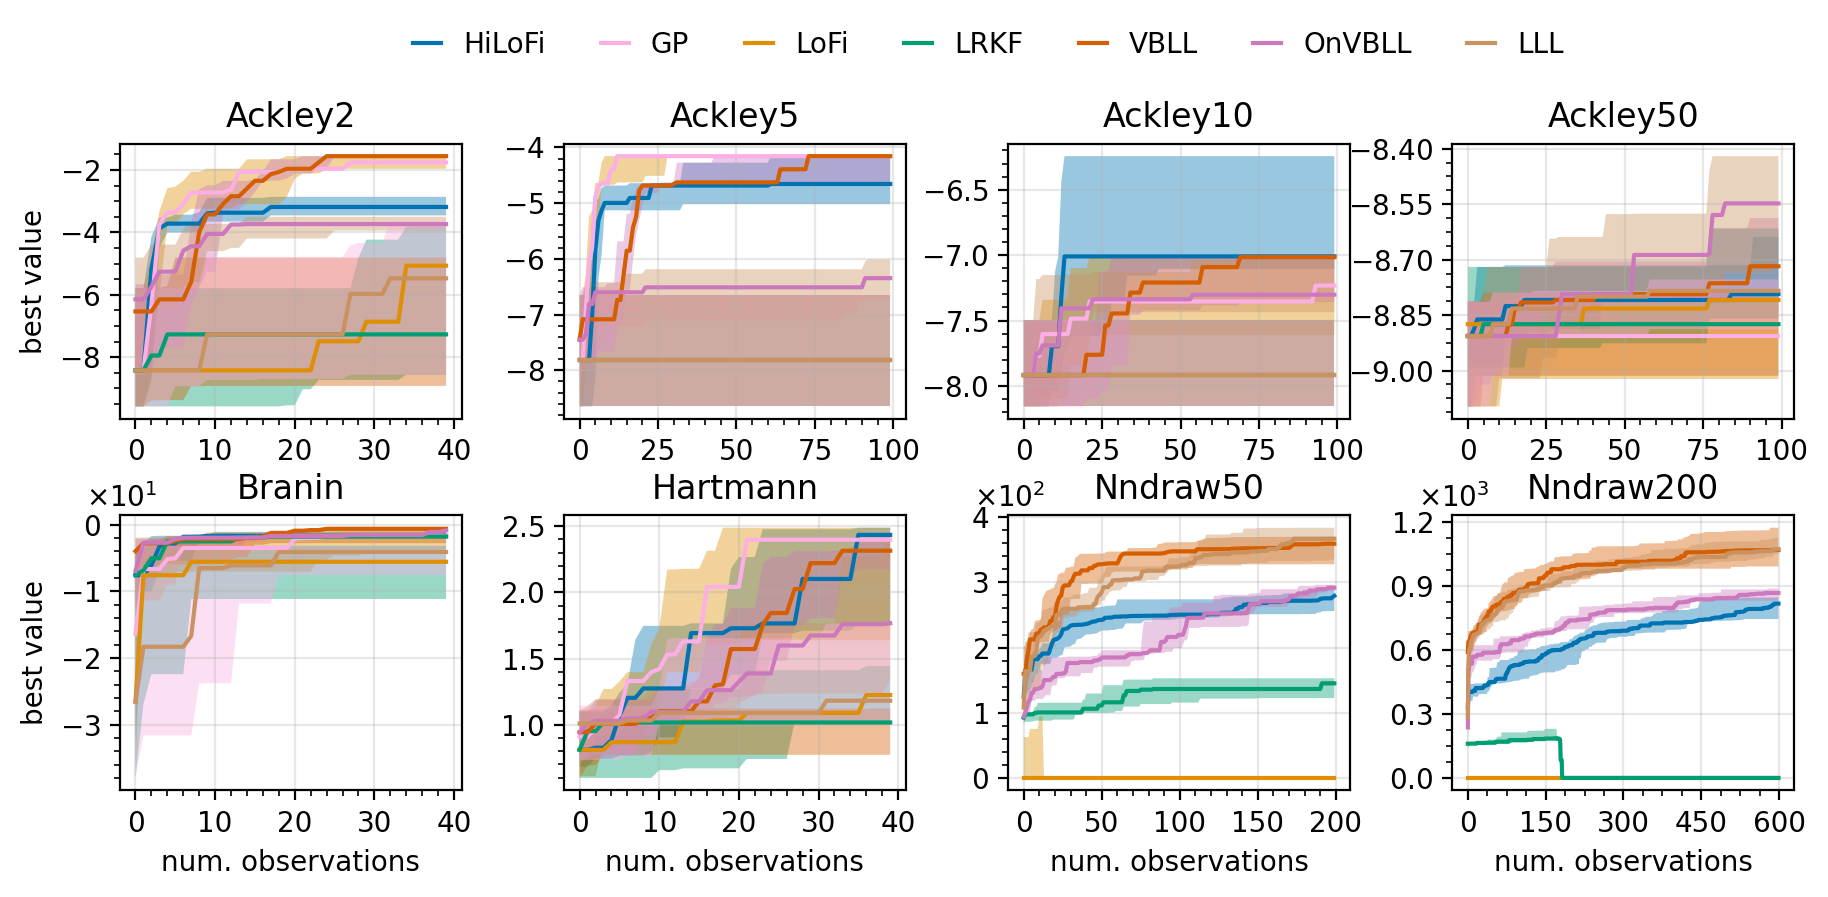

In [36]:
fig, axs = plt.subplots(2, 4, figsize=(7.2 * 1.5, 4.2))
methods = sorted(list(res["ackley2"]))

for ax, name in zip(axs.ravel(), experiments_names):
    res_experiment = res[name]
    for nmethod in sorted(res_experiment):
        name_method = map_method[nmethod]
        runs = res_experiment[nmethod]
        plot_hist(ax, runs["y_best"], label=name_method, color=colors[nmethod])
    format_ticks(ax)
    ax.set_title(name.capitalize())
    ax.grid(alpha=0.3)

axs[0,0].legend(ncol=7, bbox_to_anchor=(4.3, 1.5), frameon=False, handlelength=1)
# axs[0,0].legend(ncol=7)
# axs[-1,-1].legend()

axs[1,0].set_xlabel("num. observations")
axs[1,1].set_xlabel("num. observations")
axs[1,2].set_xlabel("num. observations")
axs[1,3].set_xlabel("num. observations")
axs[0,0].set_ylabel("best value")
axs[1,0].set_ylabel("best value")
plt.subplots_adjust(hspace=0.35, wspace=0.3)
plt.savefig(f"../figures/bayesopt-iterations-{method_explore.replace("_", "-")}.png", dpi=300, bbox_inches="tight")

In [37]:
summary = []
for ax, name in zip(axs.ravel(), experiments_names):
    res_experiment = res[name]
    for name_method in sorted(res_experiment):
        runs = res_experiment[name_method]

        summary.append({
            "y_best": runs["y_best"][:, -1].mean(),
            "y_best_std": runs["y_best"][:, -1].std(),
            "time": runs["time"],
            "method": name_method,
            "experiment": name
        })
summary =pd.DataFrame(summary)

summary["time"] = summary["time"].astype(float)

In [38]:
colors_new = {
    map_method[name]: color
    for name, color in colors.items()
}

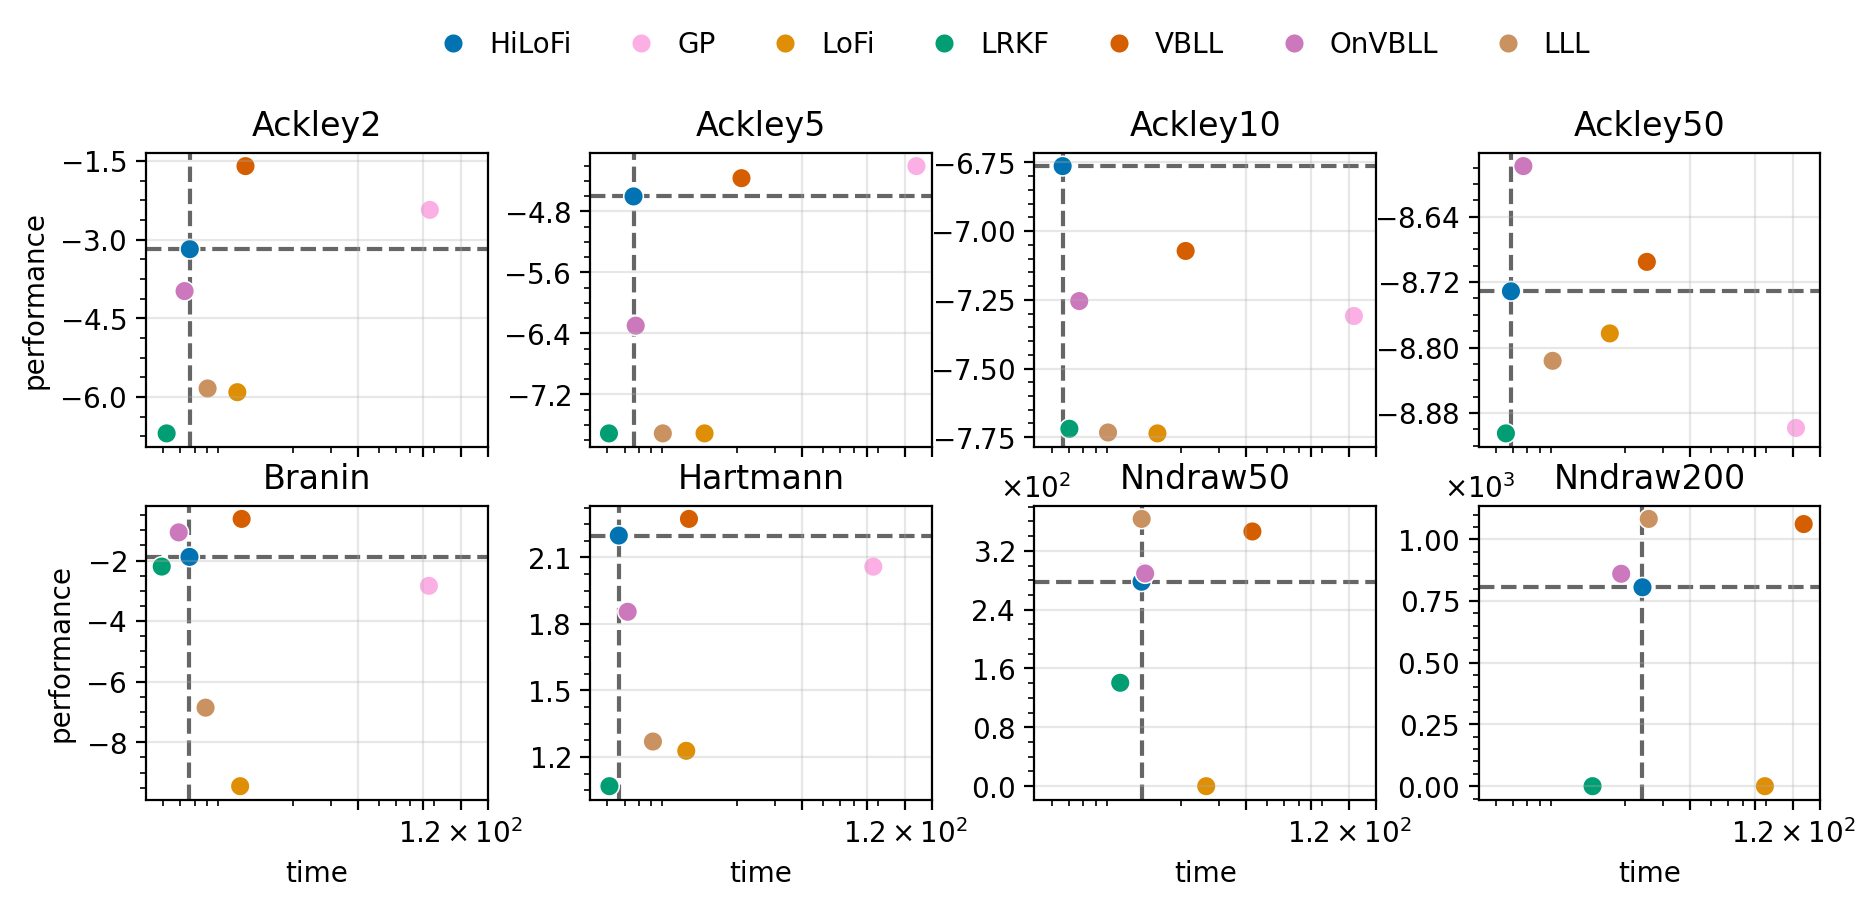

In [39]:
fig, axs = plt.subplots(2, 4, sharex=True, figsize=(7.2 * 1.5, 4.2))

experiments = summary["experiment"].unique()
for ax, experiment in zip(axs.ravel(), experiments_names):
    sns.scatterplot(
        x="time",
        y="y_best",
        hue="method",
        data=(
            summary
            .assign(method=summary["method"].apply(lambda x: map_method[x]))
            .query("experiment == @experiment")
        ),
        ax=ax,
        palette=colors_new,
        s=50
    )
    
    v = summary.query("experiment == @experiment").query("method == 'FLoRES'")
    y = v["y_best"].item()
    x = v["time"].item()

    ax.axhline(y=y, color="black", linestyle="--", zorder=0, alpha=0.6)
    ax.axvline(x=x, color="black", linestyle="--", zorder=0, alpha=0.6)
    ax.set_title(experiment.capitalize())
    ax.grid(alpha=0.3)
    ax.set_ylabel("")
    ax.legend([], frameon=False)
    ax.set_xscale("log")
    format_ticks(ax)
    plt.grid(alpha=0.3)
axs[0,0].set_ylabel("performance")
axs[1,0].set_ylabel("performance")

plt.subplots_adjust(wspace=0.3)
legend = axs[0,0].legend(ncol=7, bbox_to_anchor=(4.3, 1.5), frameon=False, handlelength=1)
# axs[0,0].legend(loc="upper right", bbox_to_anchor=(1.9, 1.0), frameon=False)
# plt.savefig("../figures/bayesopt-time-performance.png", dpi=300, bbox_inches="tight")

In [40]:
summary.pivot_table(index="method", columns="experiment")["y_best"]

experiment,ackley10,ackley2,ackley5,ackley50,branin,hartmann,nndraw200,nndraw50
method,,,,,,,,
FLoRES,-6.763535,-3.181227,-4.602024,-8.731215,-1.880822,2.199012,805.431274,277.969543
GP,-7.308882,-2.432426,-4.204634,-8.898325,-2.835982,2.058608,NaN,NaN
LOFI,-7.735974,-5.906063,-7.710509,-8.782741,-9.449255,1.227836,0.000000,0.000000
LRKF,-7.719150,-6.690907,-7.710509,-8.904983,-2.200639,1.068193,0.000000,140.578674
VBLL,-7.072278,-1.598789,-4.362828,-8.695254,-0.626927,2.274089,1061.518311,346.322510
VBLL-greedy,-7.254537,-3.979560,-6.297515,-8.578159,-1.071544,1.855081,860.188293,289.181213
laplace,-7.732709,-5.834692,-7.710509,-8.816259,-6.857860,1.269688,1082.358643,363.377045


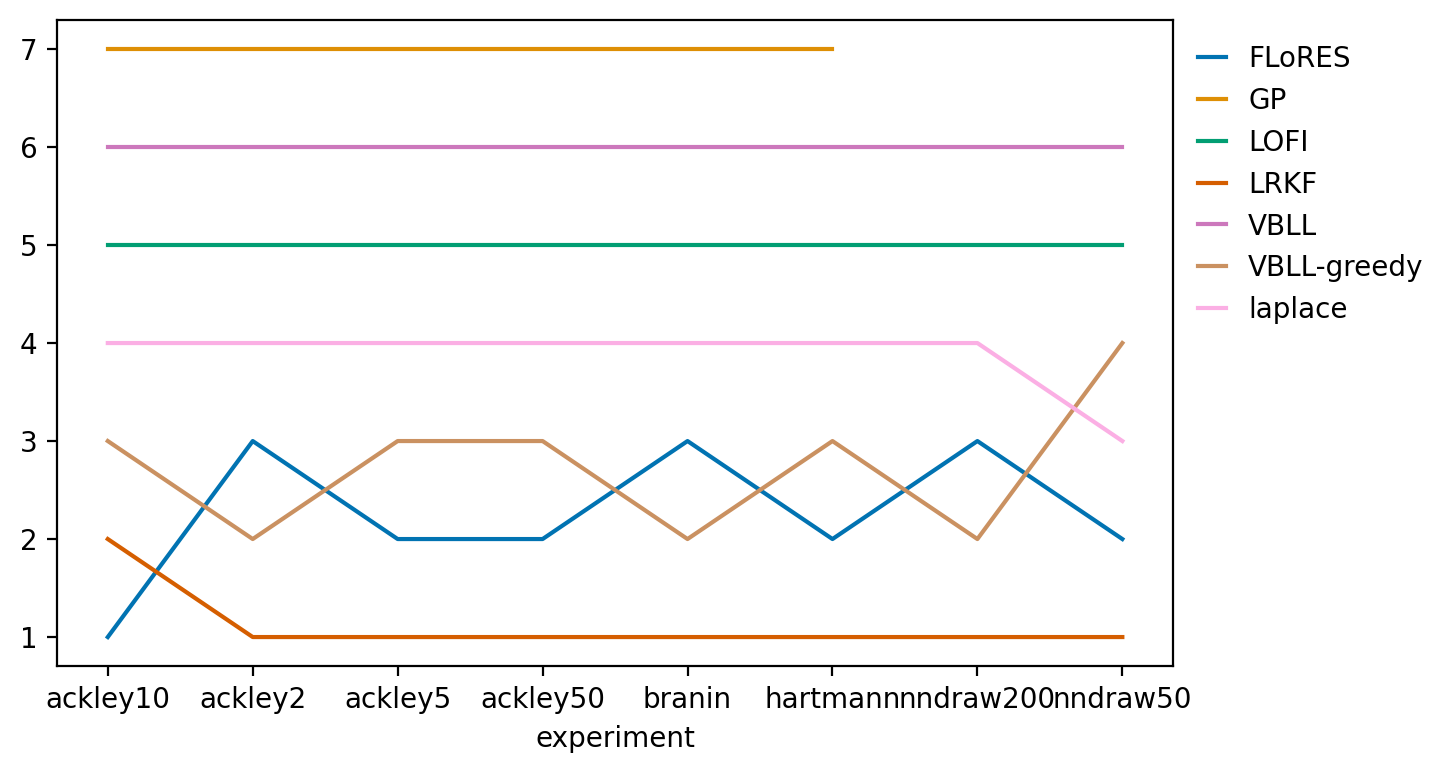

In [41]:
rank_time = summary.pivot_table(index="method", columns="experiment")["time"].rank(axis=0)
rank_time.T.plot()
plt.legend(bbox_to_anchor=(1,1), handlelength=1, frameon=False)

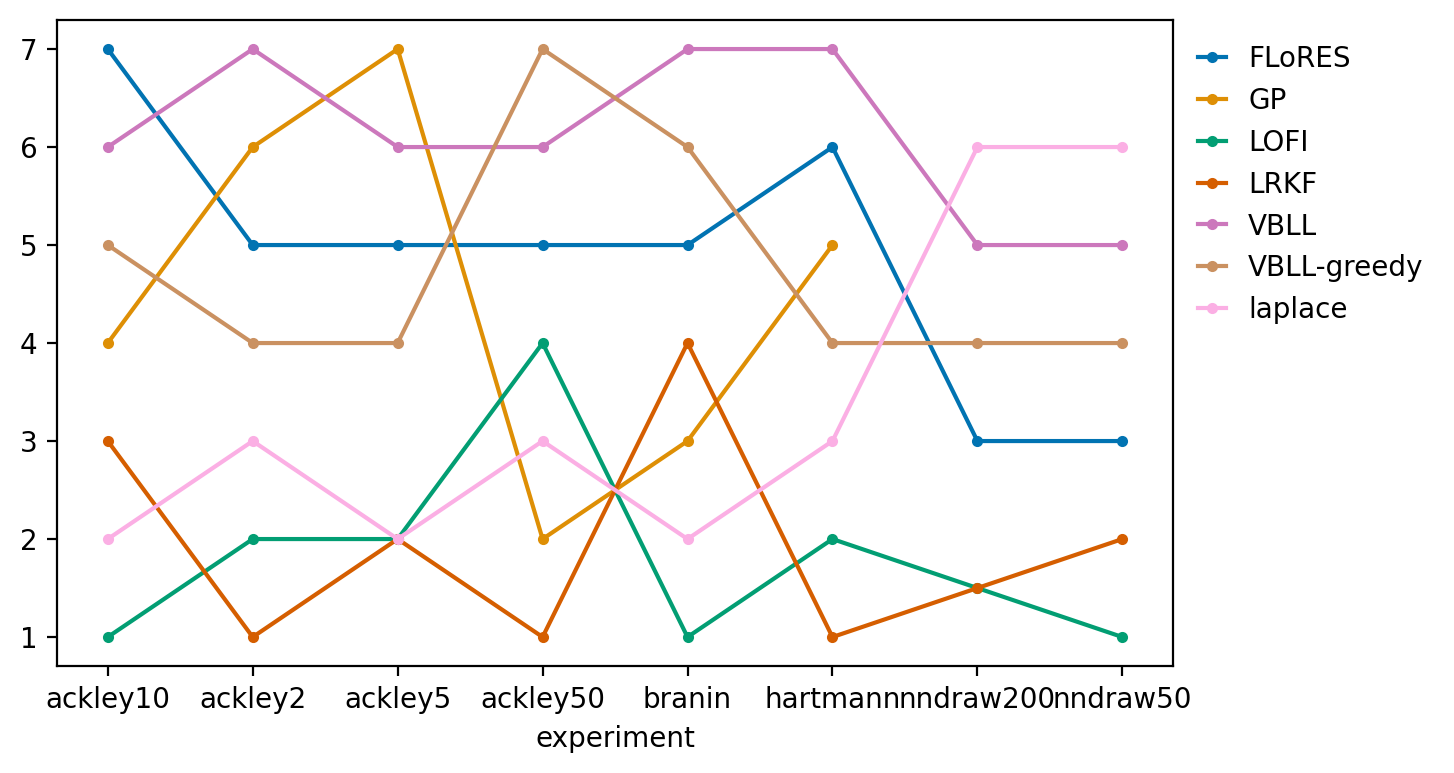

In [42]:
rank_ybest = summary.pivot_table(index="method", columns="experiment")["y_best"].rank(axis=0)
rank_ybest.T.plot(marker="o", markersize=3)
plt.legend(bbox_to_anchor=(1,1), handlelength=1, frameon=False)

In [43]:
rank_time_melt = rank_time.reset_index().melt("method").rename({"value": "time"}, axis=1)
rank_ybest_melt = rank_ybest.reset_index().melt("method").rename({"value": "ybest"}, axis=1)

In [44]:
rank_melt = pd.merge(rank_time_melt, rank_ybest_melt, on=["method", "experiment"])

In [45]:
mean_ranks = (
    rank_melt.groupby("method")[["time", "ybest"]].agg(["mean", "std"])
)

mean_ranks = mean_ranks.rename({"median": "mean"}, axis=1, level=1)

In [46]:
mean_ranks

time             ybest          
              mean       std    mean       std
method                                        
FLoRES       2.250  0.707107  4.8750  1.356203
GP           7.000  0.000000  4.5000  1.870829
LOFI         5.000  0.000000  1.8125  0.997765
LRKF         1.125  0.353553  1.9375  1.083562
VBLL         6.000  0.000000  6.1250  0.834523
VBLL-greedy  2.750  0.707107  4.7500  1.164965
laplace      3.875  0.353553  3.3750  1.685018

In [47]:
from matplotlib.lines import Line2D

custom_legend = [
    Line2D([0], [0], color=color, lw=1, marker="o", markersize=3)
    for method, color in colors.items()
]

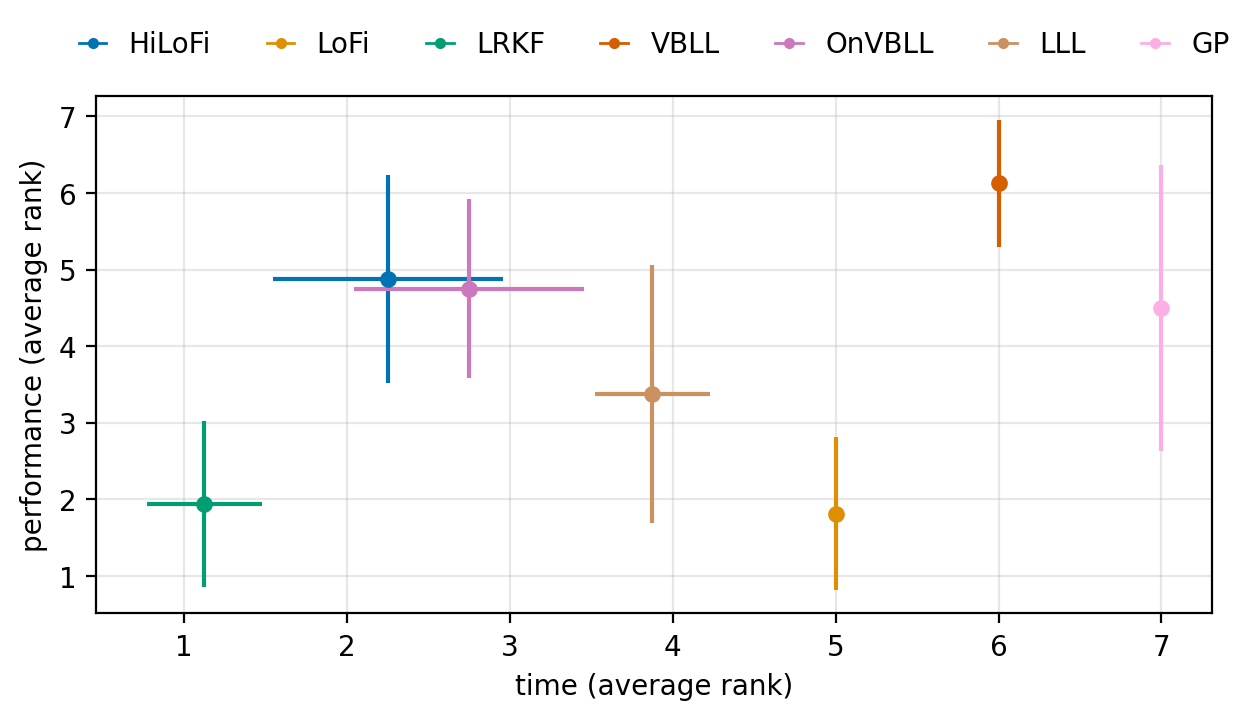

In [48]:
fig, ax = plt.subplots(figsize=(7.2, 4.2 * 0.8))

for method in methods:
    ax.errorbar(
        x=mean_ranks.xs("mean", axis=1, level=1)["time"][method],
        y=mean_ranks.xs("mean", axis=1, level=1)["ybest"][method],
        fmt="o",
        yerr=mean_ranks.xs("std", axis=1, level=1)["ybest"][method],
        xerr=mean_ranks.xs("std", axis=1, level=1)["time"][method],
        color=colors[method],
        markersize=5,
    )
# sns.scatterplot(
#     x="time",
#     y="ybest",
#     hue="method",
#     data=mean_ranks.xs("mean", axis=1, level=1).reset_index(),
# )

# plt.legend(bbox_to_anchor=(1,1))
plt.legend(
    custom_legend, [map_method[name] for name in colors],
    loc="center", ncol=7, bbox_to_anchor=(1/2, 1.1),
    handlelength=1, frameon=False
)
plt.xlabel("time (average rank)")
plt.ylabel("performance (average rank)")
plt.grid(alpha=0.3);
# plt.savefig("../figures/bayesopt-time-performance-scatter.png", dpi=300, bbox_inches="tight")

## Joint plot

In [49]:
from matplotlib.gridspec import GridSpec
from itertools import product

In [50]:
gs_indices = list(product(range(2), range(4)))

In [51]:
summary["log_time"] = np.log(summary["time"])

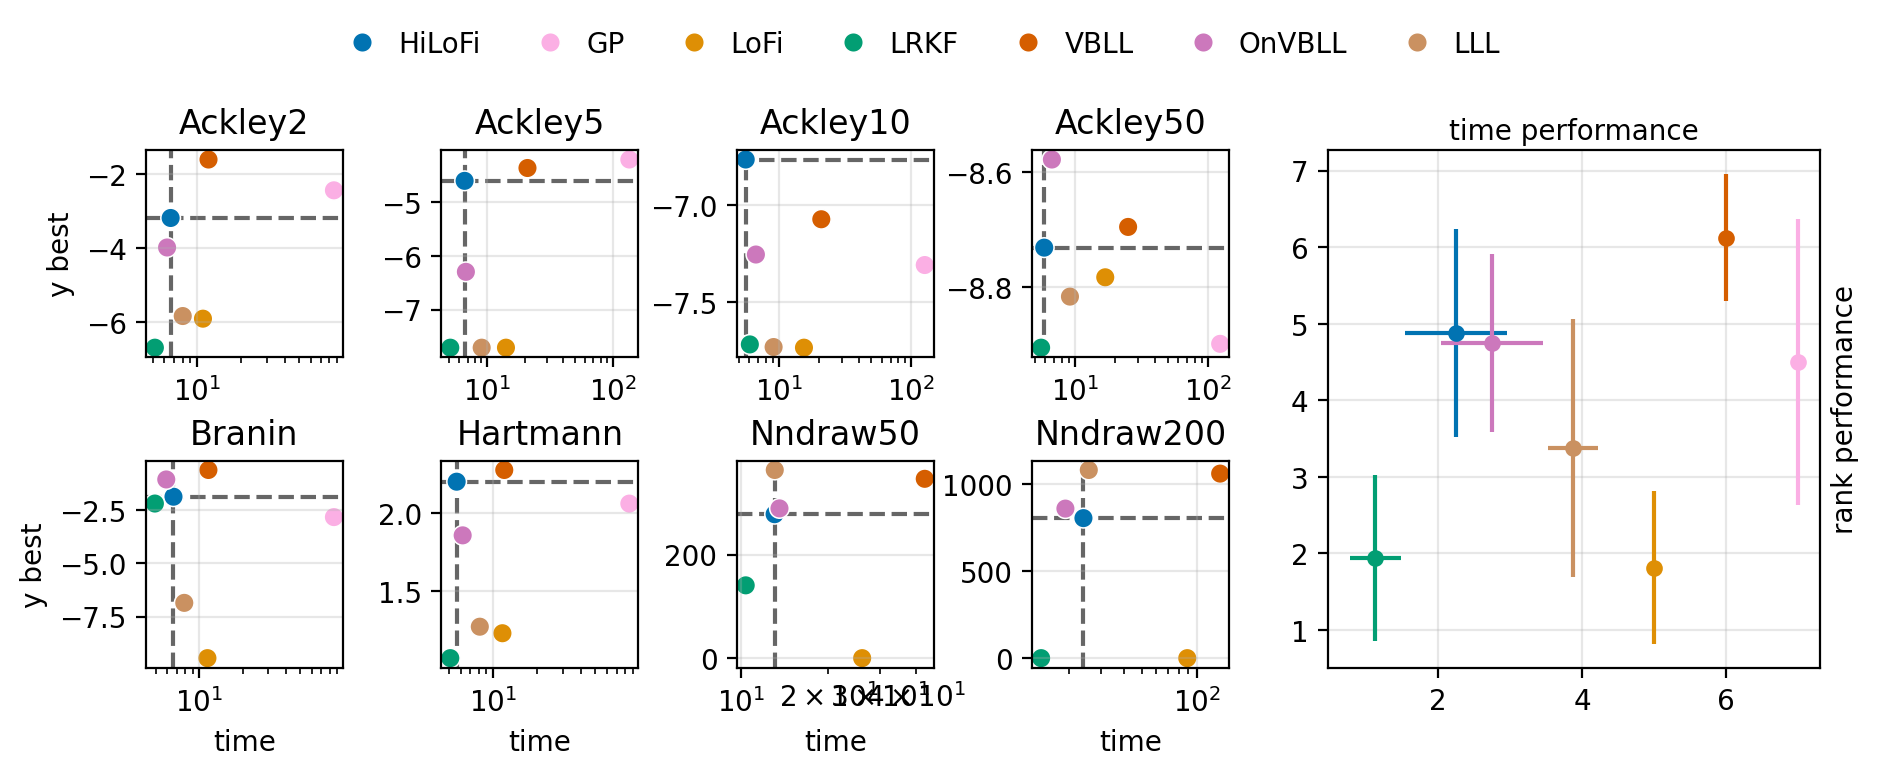

In [52]:
gs = GridSpec(2, 6)

fig = plt.figure(figsize=(7.2 * 1.5, 4.2 * 0.8))

experiments = summary["experiment"].unique()
for ix, experiment in zip(gs_indices, experiments_names):
    ax = fig.add_subplot(gs[ix])
    sns.scatterplot(
        x="time",
        y="y_best",
        hue="method",
        data=(
            summary
            .assign(method=summary["method"].apply(lambda x: map_method[x]))
            .query("experiment == @experiment")
        ),
        ax=ax,
        palette=colors_new,
        s=50
    )
    
    v = summary.query("experiment == @experiment").query("method == 'FLoRES'")
    y = v["y_best"].item()
    x = v["time"].item()

    ax.axhline(y=y, color="black", linestyle="--", zorder=0, alpha=0.6)
    ax.axvline(x=x, color="black", linestyle="--", zorder=0, alpha=0.6)
    ax.set_title(experiment.capitalize())
    ax.grid(alpha=0.3)
    ax.set_ylabel("")
    ax.legend([], frameon=False)
    ax.set_xscale("log")
    # format_ticks(ax)
    if ix[0] == 0:
        ax.set_xlabel("")
    if ix[1] == 0:
        ax.set_ylabel("y best")
    if (ix[0] == 0) and (ix[1] == 0):
        ax.legend(ncol=7, bbox_to_anchor=(7.0, 1.7), frameon=False, handlelength=1)
        
    plt.grid(alpha=0.3)

ax = fig.add_subplot(gs[:, -2:])
for method in methods:
    ax.errorbar(
        x=mean_ranks.xs("mean", axis=1, level=1)["time"][method],
        y=mean_ranks.xs("mean", axis=1, level=1)["ybest"][method],
        fmt="o",
        yerr=mean_ranks.xs("std", axis=1, level=1)["ybest"][method],
        xerr=mean_ranks.xs("std", axis=1, level=1)["time"][method],
        color=colors[method],
        markersize=5,
    )

ax.grid(alpha=0.3)
ax.set_ylabel("rank performance")
ax.yaxis.set_label_position("right")

ax.set_xlabel("time performance")
ax.xaxis.set_label_position("top")



plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.savefig("../figures/bayesopt-time-performance-scatter.png", dpi=300, bbox_inches="tight")

## Ackley 1d: Gaussian process with Matern Kernel

In [100]:
def objective_fn(x):
    return -test_functions.ackley(x, lbound=-4, ubound=5)
x_test = jnp.zeros(1)
dim = len(x_test)

In [349]:
key = jax.random.PRNGKey(314)
x = jax.random.uniform(key, minval=0, maxval=1, shape=(10,))[:, None]
y = jax.vmap(objective_fn)(x)

In [343]:
x_test = jnp.linspace(0, 1, 500)[:, None]
y_test = jax.vmap(objective_fn)(x_test)

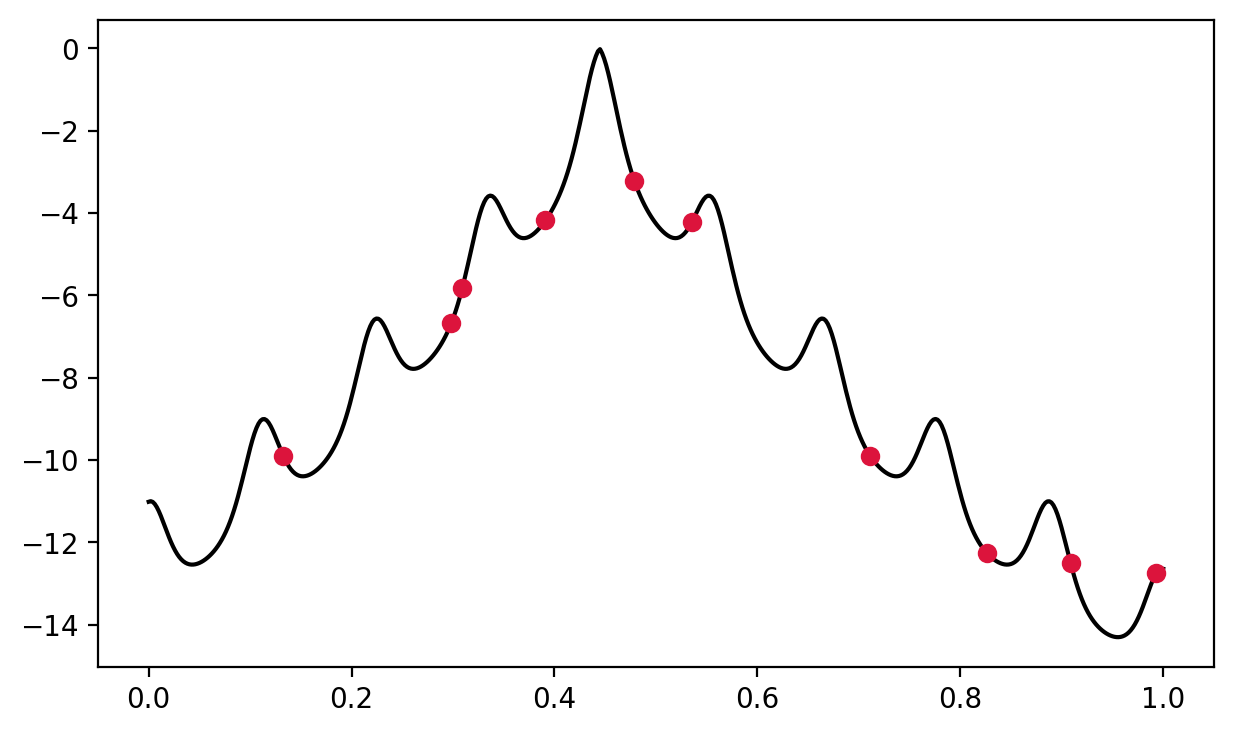

In [344]:
plt.scatter(x, y, c="crimson")
plt.plot(x_test, y_test, c="black", zorder=0)

## Bayesopt

In [64]:
from rebayes_mini.methods import gaussian_process as gp

In [65]:
keys = jax.random.split(key, 20)

In [66]:
kernel = gp.matern_kernel(length_scale=0.1, nu=5/2)
agent = gp.GaussianProcessRegression(obs_variance=0.0, kernel=kernel)
bel_init = agent.init_bel(dim_in=1, buffer_size=10)

In [67]:
bel, _ = agent.scan(bel_init, y, x)

In [68]:
@partial(jax.vmap, in_axes=(0, None, None))
def eval_fn(key, bel, x):
    fn = agent.sample_fn(key, bel)
    return fn(x) 

y_samples = eval_fn(keys, bel, x_test).squeeze()

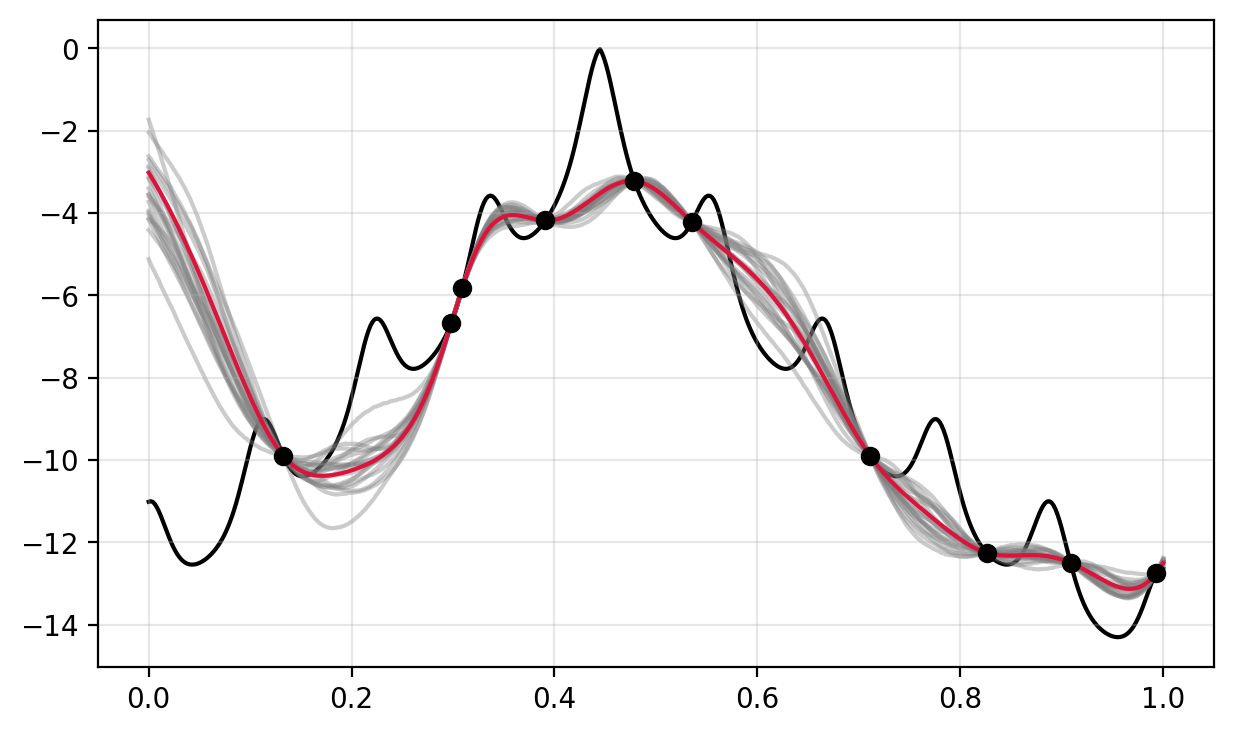

In [69]:
plt.plot(x_test, y_test, c="black", zorder=0)
plt.plot(x_test, agent.mean_fn(bel, x_test), c="crimson")
plt.scatter(x, y, c="black", zorder=3)
plt.grid(alpha=0.3)
plt.plot(x_test, y_samples.T, c="tab:gray", alpha=0.4, zorder=0);

In [70]:
bel_update = agent.update(bel_init, y[0], x[0])

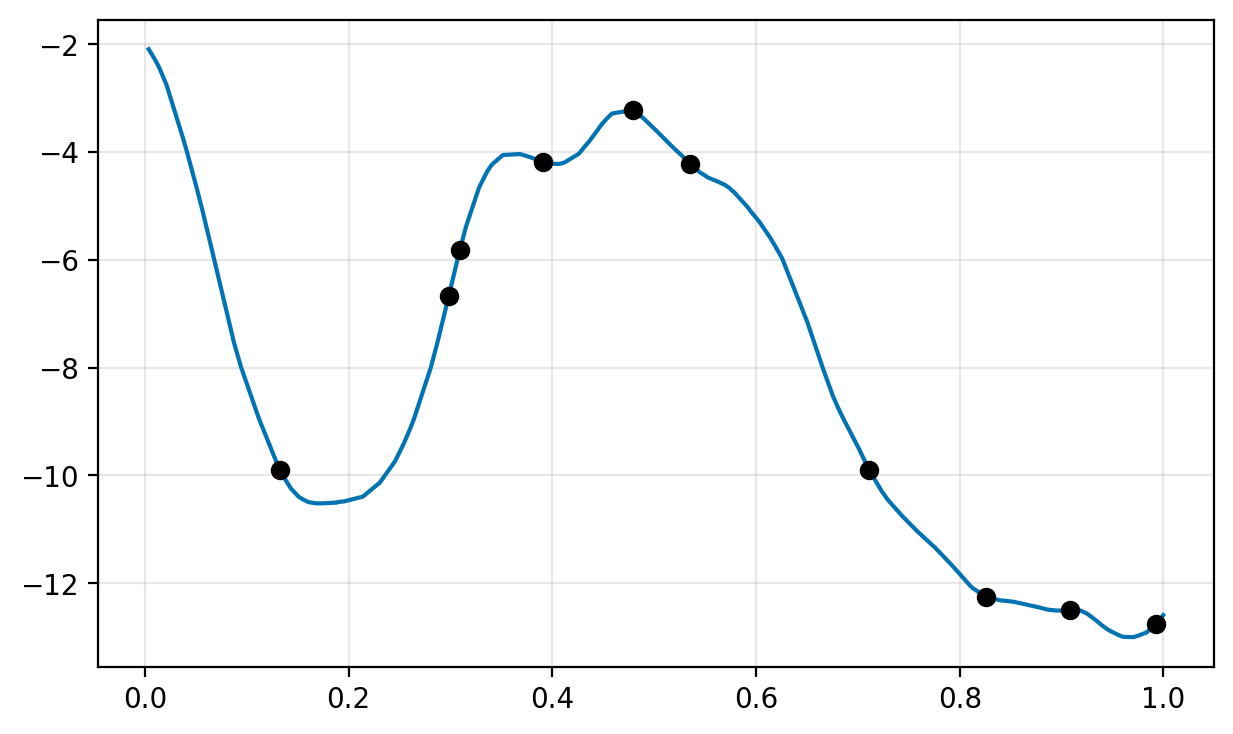

In [71]:
n_eval = 200
x_eval = jnp.sort(jax.random.uniform(key, minval=0, maxval=1, shape=(n_eval, 1)), axis=0)

fn = agent.sample_fn(key, bel)
y_eval = fn(x_eval)

plt.plot(x_eval, y_eval)
plt.scatter(x, y, c="black", zorder=3)
plt.grid(alpha=0.3)

# VBLL

In [72]:
import optax
from rebayes_mini.methods import replay_sgd
from flax.training.train_state import TrainState
from vbll_fifo import Regression, FifoVBLL

In [73]:
class VBLLMLP(nn.Module):
    n_hidden: int = 180

    @nn.compact
    def encode(self, x):
        x = nn.Dense(self.n_hidden)(x)
        x = nn.elu(x)
        x = nn.Dense(self.n_hidden)(x)
        x = nn.elu(x)
        x = nn.Dense(self.n_hidden)(x)
        x = nn.elu(x)
        return x

    @nn.compact
    def __call__(self, x):
        x = self.encode(x)
        x = Regression(
            in_features=self.n_hidden, out_features=1,
            wishart_scale=0.1,
            regularization_weight=1 / 10.0,
        )(x)
        return x

In [74]:
vbll = VBLLMLP()
params_init = vbll.init(key_init_params, x_test[:, None])

In [75]:
def lossfn(params, counter, x, y, apply_fn):
    res = apply_fn(params, x)
    return res.train_loss_fn(y, counter)

In [86]:
%%time
agent = FifoVBLL(
    vbll.apply,
    lossfn,
    tx=optax.adamw(1e-3),
    buffer_size=10,
    dim_features=1,
    dim_output=1,
    n_inner=10_000
)

bel_init = agent.init_bel(params_init)
bel_final, _ = agent.scan(bel_init, y, x)
bel_final = jax.block_until_ready(bel_final)

CPU times: user 2.24 s, sys: 61.3 ms, total: 2.3 s
Wall time: 8.47 s


In [87]:
fn = agent.sample_fn(key_run, bel_final)
ysampled = fn(x_test)

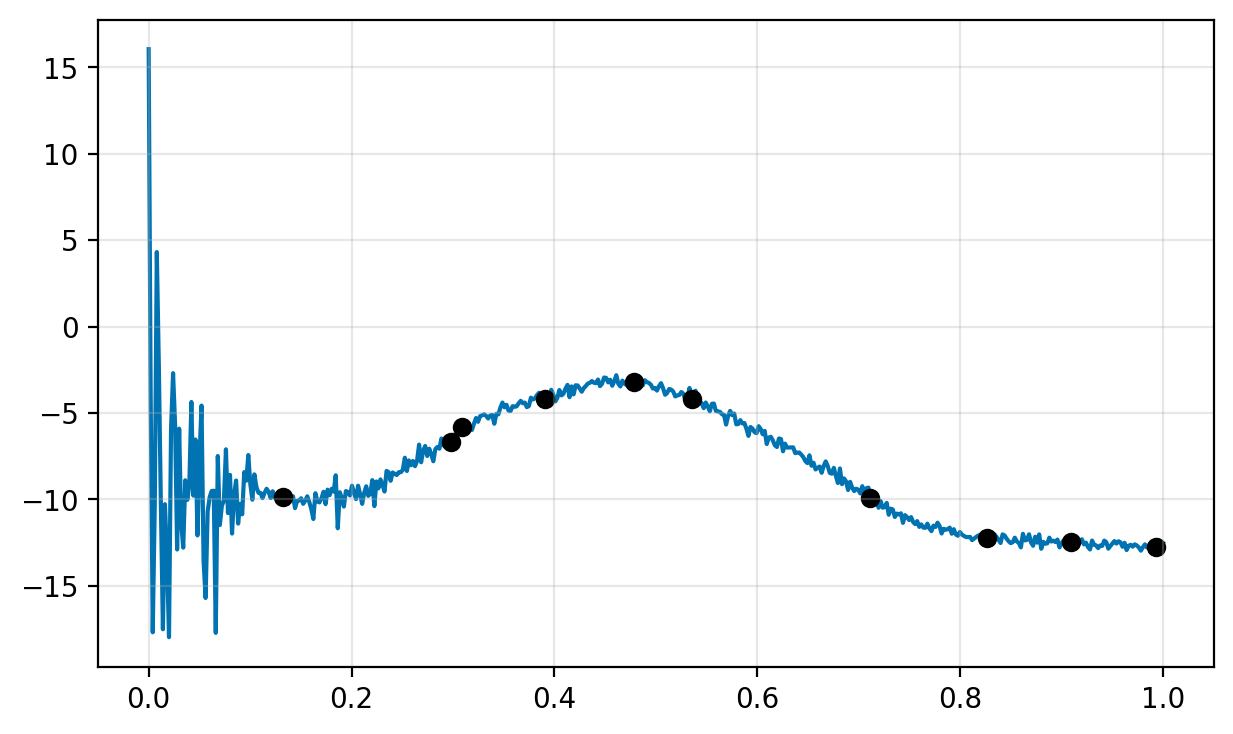

In [90]:
plt.plot(x_test, ysampled, zorder=0)
plt.scatter(x, y, c="black")
plt.grid(alpha=0.3)

In [89]:
mean = agent.mean_fn(bel_final, x_test)
sigma = jnp.sqrt(agent.cov_fn(bel_final, x_test))

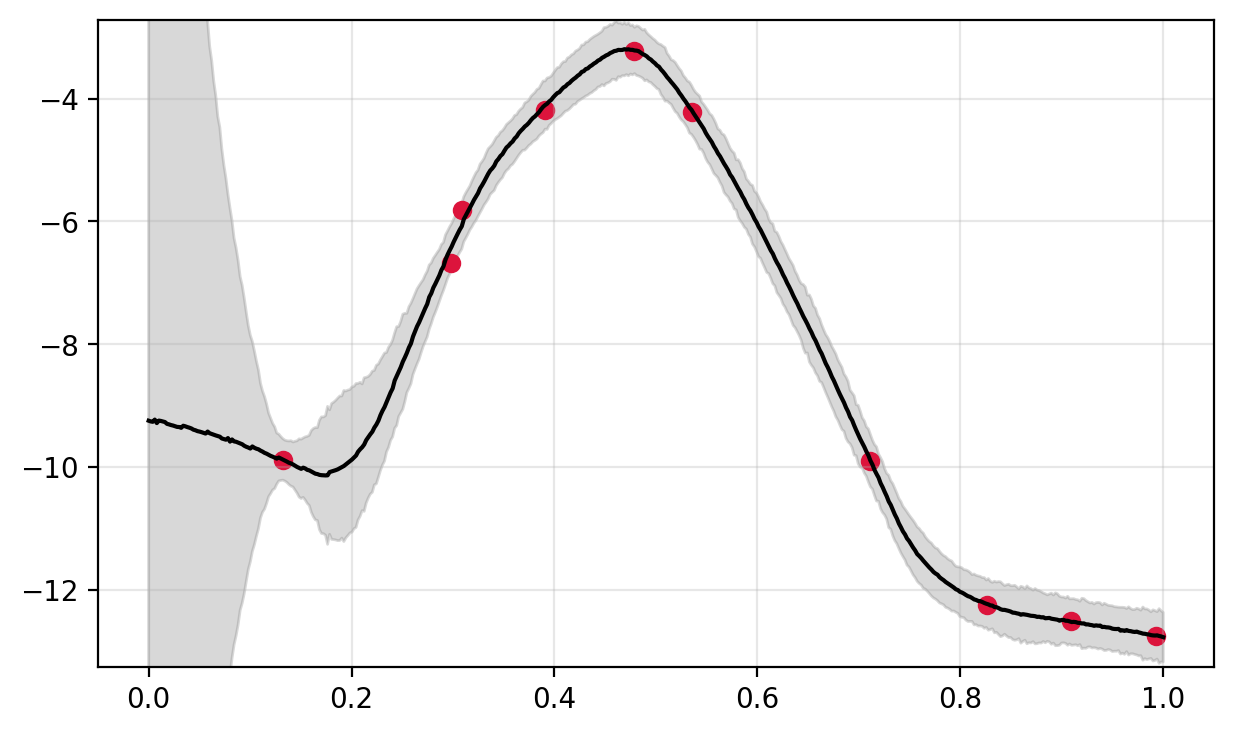

In [91]:
lbound = mean - 2 * sigma
ubound = mean + 2 * sigma

plt.plot(x_test.ravel(), mean, c="black")
ymin, ymax = plt.ylim()
plt.fill_between(x_test.ravel(), lbound, ubound, color="tab:gray", alpha=0.3)
plt.scatter(x, y, c="crimson")
plt.ylim(ymin, ymax)
plt.grid(alpha=0.3)

## Simple test

In [32]:
x_test = jnp.linspace(0, 1.2, 200)[:, None]
x = jnp.array([0.1, 0.2, 0.25, 0.8, 0.9])[:, None]
y = jnp.array([1.3, 1.1, 0.9, 0.85, 0.6])

In [33]:
kernel = gp.gaussian_kernel(sigma2=0.01)
agent = gp.GaussianProcessRegression(obs_variance=0.0, kernel=kernel)
bel_init = agent.init_bel(dim_in=1, buffer_size=10)
bel, _ = agent.scan(bel_init, y, x)

In [34]:
keys = jax.random.split(key, 20)

In [35]:
@partial(jax.vmap, in_axes=(0, None, None))
def eval_fn(key, bel, x):
    fn = agent.sample_fn(key, bel)
    return fn(x)

In [36]:
y_samples = eval_fn(keys, bel, x_test).squeeze()

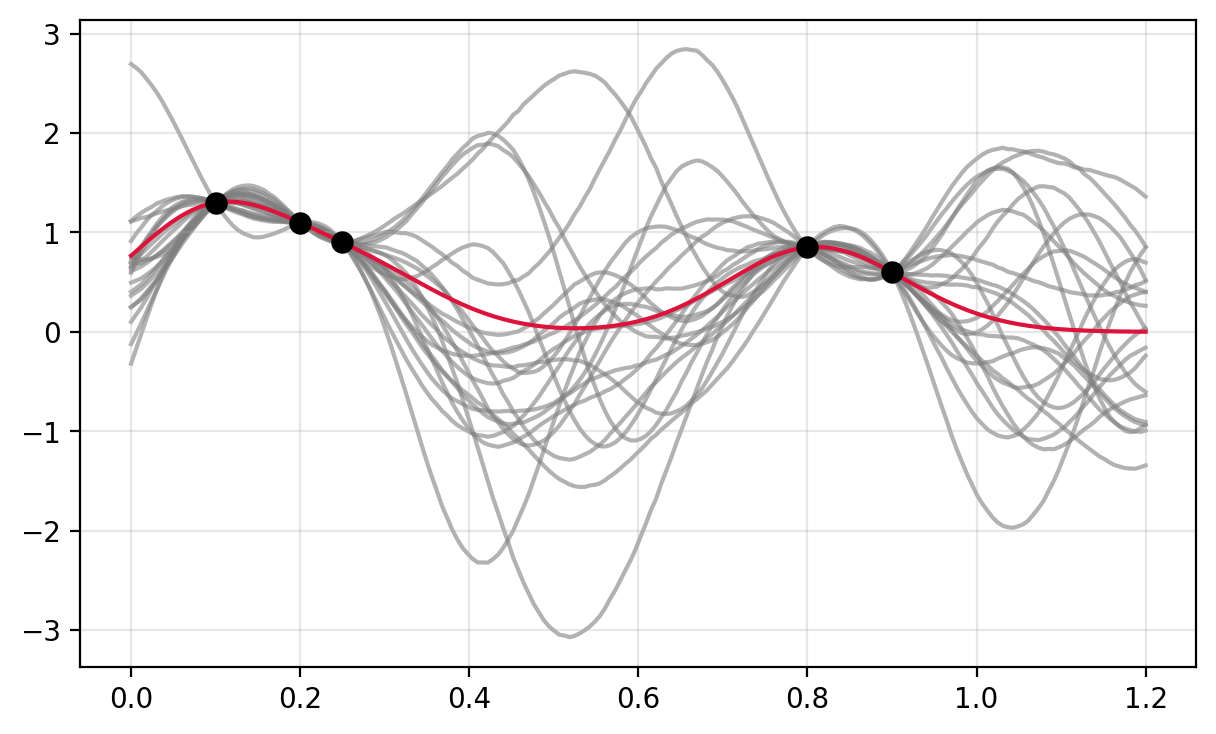

In [37]:
yhat = agent.mean_fn(bel, x_test)
plt.scatter(x, y, c="black", s=50, zorder=3)
plt.plot(x_test, yhat, c="crimson")
plt.plot(x_test, y_samples.T, c="tab:gray", alpha=0.6, zorder=0)
plt.grid(alpha=0.3)